大阪萬博是希望還是災難？

資料來源為PTT和網路新聞，總共111筆資料，時間為2025.01至2025.05。PTT資料為79筆，網路新聞資料為32筆

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [4]:
#匯入資料
df = pd.read_csv('./raw_data/expo_all.csv', encoding = 'UTF-8')
df.head(3)

,system_id,artTitle,artDate,artCatagory,artUrl,artContent,dataSource
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,國際,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,appleDaily
1,2,大阪世博13日正式開幕 觀展準備一次看,2025/4/12 15:49,國際,https://news.ebc.net.tw/news/world/483626,2025年世界博覽會（大阪世博）今天舉行開幕儀式，明天開展。這是自2005年「愛．地球博」以...,EBC
2,3,日美關稅談判內幕 川普要求多進口美車 互贈中製紀念品,2025/4/20 13:16,國際,https://news.ebc.net.tw/news/world/485389,美國總統川普關稅戰，日本是首波談判國家之一，日本談判代表回國後透露了會談細節，川普親自出馬毫...,EBC


In [12]:
MetaData = df.copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artCatagory', 'dataSource'], axis=1)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artTitle,artDate,artUrl,artContent,sentence
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...
1,2,大阪世博13日正式開幕 觀展準備一次看,2025/4/12 15:49,https://news.ebc.net.tw/news/world/483626,2025年世界博覽會（大阪世博）今天舉行開幕儀式，明天開展。這是自2005年「愛．地球博」以...,年世界博覽會大阪世博今天舉行開幕儀式明天開展這是自年愛地球博以來世博時隔年再次在日本舉行為參...
2,3,日美關稅談判內幕 川普要求多進口美車 互贈中製紀念品,2025/4/20 13:16,https://news.ebc.net.tw/news/world/485389,美國總統川普關稅戰，日本是首波談判國家之一，日本談判代表回國後透露了會談細節，川普親自出馬毫...,美國總統川普關稅戰日本是首波談判國家之一日本談判代表回國後透露了會談細節川普親自出馬毫無預警...


In [13]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [14]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [15]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from c:\Users\User\OneDrive\桌面\社群媒體分析\SMA_2025S\社媒期末專案\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u6b506bc0c56c1017edf779db9ea79743.cache
Loading model cost 1.693 seconds.
Prefix dict has been built successfully.


,system_id,artTitle,artDate,artUrl,artContent,sentence,word
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,余平
1,2,大阪世博13日正式開幕 觀展準備一次看,2025/4/12 15:49,https://news.ebc.net.tw/news/world/483626,2025年世界博覽會（大阪世博）今天舉行開幕儀式，明天開展。這是自2005年「愛．地球博」以...,年世界博覽會大阪世博今天舉行開幕儀式明天開展這是自年愛地球博以來世博時隔年再次在日本舉行為參...,綜合
2,3,日美關稅談判內幕 川普要求多進口美車 互贈中製紀念品,2025/4/20 13:16,https://news.ebc.net.tw/news/world/485389,美國總統川普關稅戰，日本是首波談判國家之一，日本談判代表回國後透露了會談細節，川普親自出馬毫...,美國總統川普關稅戰日本是首波談判國家之一日本談判代表回國後透露了會談細節川普親自出馬毫無預警...,外電


In [16]:
expo_df = MetaData.copy()
expo_df.head(3)

,system_id,artTitle,artDate,artUrl,artContent,sentence
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...
1,2,大阪世博13日正式開幕 觀展準備一次看,2025/4/12 15:49,https://news.ebc.net.tw/news/world/483626,2025年世界博覽會（大阪世博）今天舉行開幕儀式，明天開展。這是自2005年「愛．地球博」以...,年世界博覽會大阪世博今天舉行開幕儀式明天開展這是自年愛地球博以來世博時隔年再次在日本舉行為參...
2,3,日美關稅談判內幕 川普要求多進口美車 互贈中製紀念品,2025/4/20 13:16,https://news.ebc.net.tw/news/world/485389,美國總統川普關稅戰，日本是首波談判國家之一，日本談判代表回國後透露了會談細節，川普親自出馬毫...,美國總統川普關稅戰日本是首波談判國家之一日本談判代表回國後透露了會談細節川普親自出馬毫無預警...


In [17]:
# 保留需要的欄位
expo_df = expo_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
expo_df['word'] = expo_df.sentence.apply(getToken).map(' '.join)

expo_df.head()

,system_id,sentence,word
0,1,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,余平 綜合 外電 日本 大阪 博會 今天 開幕 早就 出現 排隊 人潮 官方 商店 門口 上...
1,2,年世界博覽會大阪世博今天舉行開幕儀式明天開展這是自年愛地球博以來世博時隔年再次在日本舉行為參...,世界 博覽會 大阪 世博 今天 舉行 開幕 儀式 明天 開展 自年 地球 世博 時隔 再次 ...
2,3,美國總統川普關稅戰日本是首波談判國家之一日本談判代表回國後透露了會談細節川普親自出馬毫無預警...,美國 總統 川普 關稅 日本 首波 談判 國家 日本 談判代表 回國 透露 會談 細節 川普...
3,4,隨著日本大阪萬博會展開台灣的館也在號盛大開幕了斥資億台幣場館不只大秀台灣的晶片技術還有奈米噴...,日本 大阪 博會 展開 台灣 在號 盛大 開幕 斥資 億台幣 場館 大秀 台灣 晶片 技術 ...
4,5,日本迎來一年一度的黃金周從四月底到五月初多個連假串聯吸引大量民眾湧入機場樂園等景點氣氛熱鬧非...,日本 迎來 一年一度 黃金 周從 月底 五月 多個 連假 串聯 吸引 大量 民眾 湧入 機場...


In [18]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(expo_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一下,一九七,一二三,一二日,一亮,一人,一人份,一人個,一人僅,...,鼻孔,齊全,齊聚一堂,齊聲,齋橋,齋橋僅,龍仕柏,龍捲風,龍門,龜岡
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一下,一九七,一二三,一二日,一亮,一人,一人份,一人個,一人僅,...,鼻孔,齊全,齊聚一堂,齊聲,齋橋,齋橋僅,龍仕柏,龍捲風,龍門,龜岡
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.028948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
107,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
108,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
109,0.0,0.030090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [20]:
expo_tfidf = TFIDF_df.mean().to_frame().reset_index() ## !!
expo_tfidf.columns = ["word", "avg"]

expo_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
8338,預約,0.055612
2423,大阪,0.050730
1019,入場,0.035226
4195,日本,0.034900
359,世博,0.034772
6663,萬博,0.033300
4408,會場,0.030137
2223,場館,0.027700
4305,時間,0.027590
1539,協會,0.027220


方法2

In [22]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一下,一九七,一二三,一二日,一亮,一人,一人份,一人個,...,鼻孔,齊全,齊聚一堂,齊聲,齋橋,齋橋僅,龍仕柏,龍捲風,龍門,龜岡
0,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,4,0.0,0.028948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
107,108,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
108,109,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
109,110,0.0,0.030090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [23]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.000000
1,2,一一,0.000000
2,3,一一,0.000000
3,4,一一,0.000000
4,5,一一,0.000000
...,...,...,...
960811,107,龜岡,0.000000
960812,108,龜岡,0.000000
960813,109,龜岡,0.000000
960814,110,龜岡,0.000000


In [24]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

C:\Users\User\AppData\Local\Temp\ipykernel_5236\3283726584.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)


,word,size
765,預約,19
157,協會,13
104,入場,12
34,世博,9
462,會場,9
630,萬張,8
239,場館,8
99,價格,8
53,京都,8
452,時間,7


Bigram

In [25]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [26]:
expo_bigram = MetaData.copy()

expo_bigram["word"] = expo_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
expo_bigram = expo_bigram.explode('word')

expo_bigram.head(3)

,system_id,artTitle,artDate,artUrl,artContent,sentence,word
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,余平 綜合
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,綜合 外電
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,外電 日本


In [27]:
# 計算每個組合出現的次數
expo_bigram_count = expo_bigram['word'].value_counts().reset_index()

expo_bigram_count.sort_values('count', ascending=False).head(10)

,word,count
0,萬博 協會,62
1,大阪 關西,52
2,時間 分鐘,43
3,大阪 萬博,43
4,關西 世博,43
5,關西 機場,41
6,大阪 世博,35
7,現場 排隊,35
8,世界 博覽會,33
9,當日 預約,28


In [28]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('./dict/expo_dict.txt')

In [29]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artTitle,artDate,artUrl,artContent,sentence,word
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,余平
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,綜合
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,外電


In [30]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artTitle,artDate,artUrl,artContent,sentence,word
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,余平 綜合
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,綜合 外電
0,1,大阪萬博周邊秒殺！ 要價400萬公仔、7年級回憶電子雞在列,2025/4/14 00:08,https://tw.nextapple.com/international/2025041...,【余平／綜合外電】日本大阪萬博會今天開幕，一早就出現排隊人潮，官方商店門口在早上9點開門後馬...,余平綜合外電日本大阪萬博會今天開幕一早就出現排隊人潮官方商店門口在早上點開門後馬上大排長龍有...,外電 日本


In [31]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(5)

[(('萬博', '協會'), 62),
 (('大阪', '關西'), 49),
 (('關西', '世博'), 43),
 (('時間', '分鐘'), 43),
 (('關西', '機場'), 41)]

In [32]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [33]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得調整edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

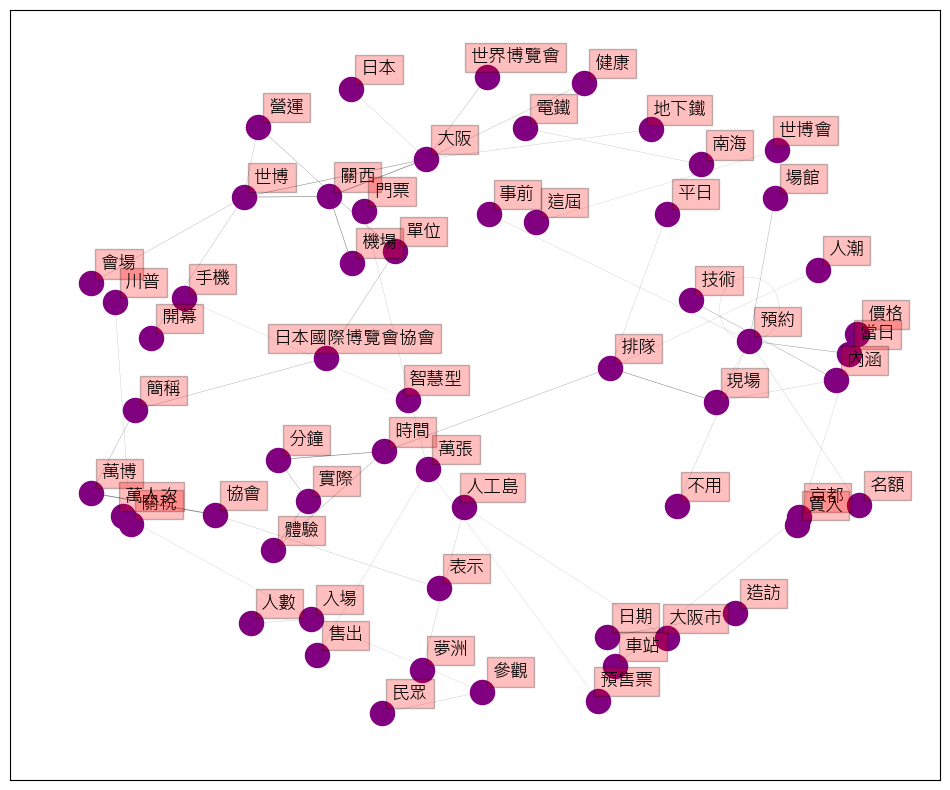

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()